In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
import logging
logging.basicConfig(level=logging.ERROR)

In [5]:
!pip install transformers==3

#Data

In [6]:
cd drive/My Drive/Colab Notebooks/experiments

/content/drive/My Drive/Colab Notebooks/experiments


In [7]:
# Use a subset for quick experiments
#data = data[:10000]

from sklearn.model_selection import train_test_split as tts
import pandas as pd
data = pd.read_csv("stockholm/wikipedia_music/verbs/wiki_verbs_labels_original_500.csv")
data = data.rename(columns={'prediction': 'label'})

# Split to train, val and test
train, test_df = tts(data[["sentence", "label"]], random_state=42, test_size=0.1)
train, val = tts(train, random_state=42, test_size=test_df.shape[0])

In [8]:
import pandas as pd
# import pytreebank

#cd drive/My Drive/Colab Notebooks/experiments/data

# Load the dataset into a pandas dataframe.
df = pd.read_csv("stockholm/wikipedia_music/verbs/wiki_verbs_labels_original_500.csv")
df = df.rename(columns={'prediction': 'label'})
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.head()

Number of training sentences: 500



,sentence,label
0,['Music is the art of arranging sounds in time...,1
1,It is one of the universal cultural aspects of...,1
2,General definitions of music include common e...,1
3,Different styles or types of music may emphas...,1
4,Music is performed with a vast range of instr...,0


In [9]:
#if label was not numeric
#from sklearn.preprocessing import LabelEncoder

#encoder = LabelEncoder()
#df.label = encoder.fit_transform(df.label)

In [10]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values.astype(str)
labels = df.label.values
labels

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

#Tokenizer

In [11]:
!pip install sentencepiece

In [12]:
from transformers import XLMRobertaTokenizer

# Load the BERT tokenizer.
print('Loading XLMRobertaTokenizer ...')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)

Loading XLMRobertaTokenizer ...


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

In [13]:
# Print the original sentence.
print('Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  ['Music is the art of arranging sounds in time to produce a composition through the elements of melody, harmony, rhythm, and timbre
Tokenized:  ['▁[', "'", 'music', '▁is', '▁the', '▁art', '▁of', '▁arran', 'ging', '▁sounds', '▁in', '▁time', '▁to', '▁produce', '▁a', '▁composition', '▁through', '▁the', '▁elements', '▁of', '▁melo', 'dy', ',', '▁har', 'mo', 'ny', ',', '▁', 'rhythm', ',', '▁and', '▁tim', 'bre']
Token IDs:  [378, 25, 94922, 83, 70, 4927, 111, 80265, 9966, 102678, 23, 1733, 47, 27489, 10, 166577, 8305, 70, 80854, 111, 106453, 1459, 4, 182, 432, 299, 4, 6, 239530, 4, 136, 5527, 4134]


#Tokenize Dataset

In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('labels:', labels)

Original:  ['Music is the art of arranging sounds in time to produce a composition through the elements of melody, harmony, rhythm, and timbre
Token IDs: tensor([     0,    378,     25,  94922,     83,     70,   4927,    111,  80265,
          9966, 102678,     23,   1733,     47,  27489,     10, 166577,   8305,
            70,  80854,    111, 106453,   1459,      4,    182,    432,    299,
             4,      6, 239530,      4,    136,   5527,   4134,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1

#Train and validation split

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  450 training samples
   50 validation samples


In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


#Train the model - XLMRobertaForSequenceClassification

In [17]:
from transformers import XLMRobertaForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification - pretrained BERT model with a single linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [18]:
params = list(model.named_parameters())

print('The XLMRoberta model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLMRoberta model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias     

#Optimizer and Learning Rate Scheduler

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) - "W" stands for weight decay fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [20]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#Train our model

In [21]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        print(b_input_ids.shape)
        print(b_input_mask.shape)
        print(b_labels.shape)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2])

  Average training loss: 0.56
  Training ep

In [24]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.56,0.40,0.85,0:00:10,0:00:00
2,0.49,0.43,0.85,0:00:10,0:00:00
3,0.47,0.41,0.85,0:00:10,0:00:00
4,0.46,0.39,0.85,0:00:10,0:00:00
5,0.45,0.35,0.85,0:00:10,0:00:00
6,0.43,0.35,0.85,0:00:10,0:00:00
7,0.39,0.38,0.87,0:00:10,0:00:00
8,0.35,0.35,0.88,0:00:10,0:00:00
9,0.32,0.35,0.82,0:00:10,0:00:00


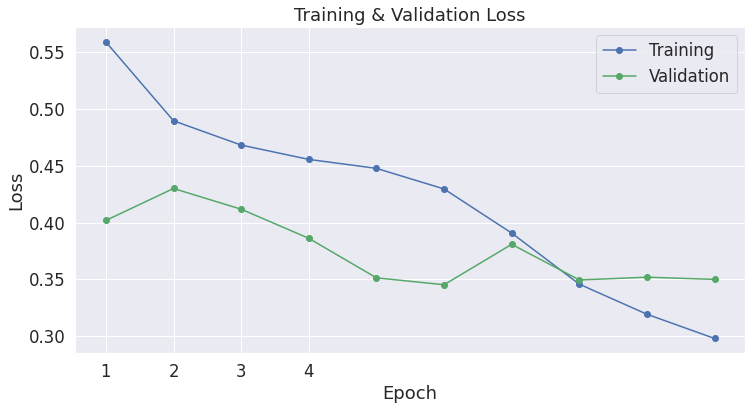

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Performance on test set

In [26]:
import pandas as pd

# # Load the dataset into a pandas dataframe.
test_df = pd.read_csv("stockholm/wikipedia_music/verbs/wiki_verbs_labels_replaced_500.csv")
test_df = test_df[test_df["prediction"] == 0]
test_df = test_df.rename(columns={'prediction': 'label'})

# # Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# # Create sentence and label lists
sentences = test_df.sentence.values.astype(str)
labels = test_df.label.values

# # Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# # For every sentence...
for sent in sentences:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
     encoded_dict = tokenizer.encode_plus(
                         sent,                      # Sentence to encode.
                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                         max_length = 64,           # Pad & truncate all sentences.
                         pad_to_max_length = True,
                         return_attention_mask = True,   # Construct attn. masks.
                         return_tensors = 'pt',     # Return pytorch tensors.
                    )
    
#     # Add the encoded sentence to the list.    
     input_ids.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
     attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Set the batch size.  
batch_size = 32  

# # Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 500



#Evaluation on test set

In [27]:
# # Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# # Put model in evaluation mode
# model.eval()

# # Tracking variables 
# predictions , true_labels = [], []

# # Predict 
# for batch in prediction_dataloader:
#   # Add batch to GPU
#   batch = tuple(t.to(device) for t in batch)
  
#   # Unpack the inputs from our dataloader
#   b_input_ids, b_input_mask, b_labels = batch
  
#   # Telling the model not to compute or store gradients, saving memory and 
#   # speeding up prediction
#   with torch.no_grad():
#       # Forward pass, calculate logit predictions
#       outputs = model(b_input_ids, token_type_ids=None, 
#                       attention_mask=b_input_mask)

#   logits = outputs[0]

#   # Move logits and labels to CPU
#   logits = logits.detach().cpu().numpy()
#   label_ids = b_labels.to('cpu').numpy()
  
#   # Store predictions and true labels
#   predictions.append(logits)
#   true_labels.append(label_ids)


# print('    DONE.')
# print('    predictions:::',predictions)
# print('    true_labels:::',true_labels)

In [28]:
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [29]:
my_submission = pd.DataFrame()
my_submission['sentence'] = test_df['sentence']
my_submission['correct_label'] = test_df['label']
#my_submission['polarity'] = test_df['polarity']
#my_submission['intensity'] = test_df['intensity']
#my_submission['source_concept'] = test_df['source_concept']
#my_submission['target_concept'] = test_df['target_concept']

In [30]:
final_preds = []
for p in predictions:
    for i in p:
        final_preds.append(np.argmax(i))

In [31]:
my_submission['label'] = final_preds

In [32]:
my_submission['label'] = my_submission['label'].map({0:0, 1:1})

In [33]:
my_submission.head()

,sentence,correct_label,label
4,Music is filled with a vast range of instrume...,0,1
5,The word originated from Greek μουσική (mousi...,0,0
6,"In its most general form, the activities portr...",0,1
7,Ancient Greek and Indian philosophers conceiv...,0,1
9,"However, 20th-century composer John Cage theo...",0,1


In [34]:
my_submission.shape

(100, 3)

In [35]:
test_df.label.value_counts()

0    100
Name: label, dtype: int64

In [36]:
final = my_submission[(my_submission['correct_label'] == 0) & (my_submission['label'] ==1)]

In [37]:
final.shape

(56, 3)

In [39]:
my_submission.to_csv('stockholm/wikipedia_music/verbs/wiki_verbs_xlm_sub.csv', index=False)